# Exercise 1.3

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need

In [0]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [0]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [0]:
batch_size = 64
trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
!cd data && ls

cifar-10-batches-py  cifar-10-python.tar.gz


* Make a CNN to train on the CIFAR10 dataset

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(8),
            nn.ReLU(),
            # nn.Dropout2d(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(16*16*16, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
            # nn.Softmax(dim=1),
            # nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [0]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters()) #, lr=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [0]:
#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([64, 16, 16, 16])


In [0]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

 * Train the network and plot make a plot of the loss and accuracy for both training and with the epoch on the x-axis

In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
dict_sdg = train(model, optimizer)


Loss train: 1.470	 test: 1.272	 Accuracy train: 47.6%	 test: 57.0%



Loss train: 0.989	 test: 1.184	 Accuracy train: 65.0%	 test: 60.1%



Loss train: 0.938	 test: 1.214	 Accuracy train: 66.9%	 test: 58.1%



Loss train: 0.899	 test: 1.364	 Accuracy train: 68.1%	 test: 54.4%



Loss train: 0.879	 test: 1.321	 Accuracy train: 68.9%	 test: 57.4%



Loss train: 0.858	 test: 1.166	 Accuracy train: 69.4%	 test: 61.0%



Loss train: 0.840	 test: 1.234	 Accuracy train: 70.2%	 test: 60.8%



Loss train: 0.819	 test: 1.145	 Accuracy train: 70.9%	 test: 61.6%



Loss train: 0.806	 test: 1.222	 Accuracy train: 71.3%	 test: 59.5%



Loss train: 0.785	 test: 1.214	 Accuracy train: 72.1%	 test: 61.4%



In [0]:
optimizer = torch.optim.Adam(model.parameters()) #, lr=0.1)
dict_adam = train(model, optimizer)


Loss train: 1.760	 test: 1.479	 Accuracy train: 35.6%	 test: 47.1%



Loss train: 1.481	 test: 1.467	 Accuracy train: 46.0%	 test: 48.2%



Loss train: 1.366	 test: 1.251	 Accuracy train: 50.8%	 test: 54.6%



Loss train: 1.277	 test: 1.210	 Accuracy train: 54.0%	 test: 57.0%



Loss train: 1.203	 test: 1.146	 Accuracy train: 56.9%	 test: 59.2%



Loss train: 1.145	 test: 1.107	 Accuracy train: 59.0%	 test: 61.0%



Loss train: 1.086	 test: 1.099	 Accuracy train: 61.6%	 test: 60.9%



Loss train: 1.039	 test: 1.090	 Accuracy train: 62.9%	 test: 61.5%



Loss train: 0.991	 test: 1.055	 Accuracy train: 64.8%	 test: 62.9%



Loss train: 0.949	 test: 1.069	 Accuracy train: 66.2%	 test: 62.7%



Text(0, 0.5, 'Error')

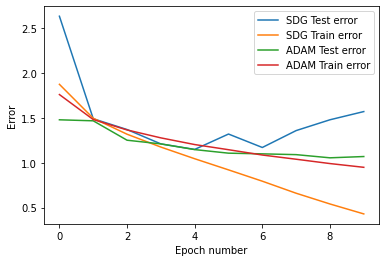

In [0]:
# Loss
plt.plot(range(10), dict_sdg['test_loss'])
plt.plot(range(10), dict_sdg['train_loss'])
plt.plot(range(10), dict_adam['test_loss'])
plt.plot(range(10), dict_adam['train_loss'])
plt.legend(('SDG Test error','SDG Train error', 'ADAM Test error', 'ADAM Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Error')

Text(0, 0.5, 'Accuracy')

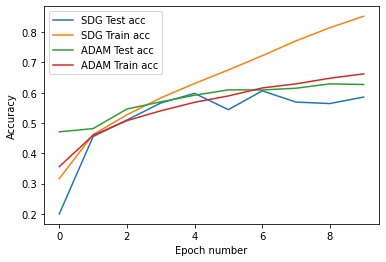

In [0]:
# Accuracy
plt.plot(range(10), dict_sdg['test_acc'])
plt.plot(range(10), dict_sdg['train_acc'])
plt.plot(range(10), dict_adam['test_acc'])
plt.plot(range(10), dict_adam['train_acc'])
plt.legend(('SDG Test acc','SDG Train acc', 'ADAM Test acc', 'ADAM Train acc'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?
* Which optimizer works best for you?
* Plot the test and test errors for both SGD and Adam in one plot
* Try adding Batch normalisation after your convolutional layers. Does it help?

## ResNet

Now you will create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below
![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [0]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, stride=1, padding=1),
        )
    def forward(self, x):
        residual = x
        out = self.convolutional(x)
        out = out + residual
        out = F.relu(out)
        return out

The following code is a sanity of your residual block network

In [0]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

Passed sanity check


We define a network that uses your `ResNetBlock`

In [0]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                # nn.Softmax(dim=1)
                                )
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

Let's train our new ResNet!

In [0]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict = train(model, optimizer)


Loss train: 1.900	 test: 1.733	 Accuracy train: 31.5%	 test: 36.8%



Loss train: 1.476	 test: 2.010	 Accuracy train: 47.1%	 test: 32.6%



Loss train: 1.268	 test: 1.309	 Accuracy train: 54.5%	 test: 53.6%



Loss train: 1.092	 test: 1.589	 Accuracy train: 61.0%	 test: 47.4%



Loss train: 0.884	 test: 1.244	 Accuracy train: 68.3%	 test: 56.6%



Loss train: 0.649	 test: 1.380	 Accuracy train: 77.0%	 test: 55.9%



Loss train: 0.417	 test: 2.223	 Accuracy train: 85.5%	 test: 49.1%



Loss train: 0.262	 test: 2.114	 Accuracy train: 91.0%	 test: 55.2%



Loss train: 0.166	 test: 2.354	 Accuracy train: 94.4%	 test: 56.1%



Loss train: 0.126	 test: 2.345	 Accuracy train: 95.9%	 test: 56.5%





Do you get nan loss at some point during training? 
This can be caused by the numerical instability of using softmax and log as two functions. 
* Change your network and loss to use a layer that combines the softmax log into one such as `nn.LogSoftmax`. You can also use `nn.CrossEntropyLoss` which also integrates `nn.NLLLoss`.